<a href="https://colab.research.google.com/github/youcefjd/heavy_objects/blob/master/Copy_of_Embedding_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.text import *

In [0]:
import umap
from PIL import Image
import matplotlib.pyplot

In [0]:
import scipy.spatial
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory_path = '/content/drive/My Drive/Bert Training' ## we will store our data in this drive

In [0]:
dfTrain = pd.read_csv(os.path.join(directory_path,'breitling_watches_new.csv'))
dfValid = pd.read_csv(os.path.join(directory_path,'rolex_watches_new.csv'))

In [0]:


dfDatasetTrain = pd.DataFrame()
dfDatasetTrain['Specs'] = dfTrain['Specs']

dfDatasetValid = pd.DataFrame()
dfDatasetValid['Specs'] = dfTrain['Specs']

dfAll = pd.concat([dfDatasetTrain, dfDatasetValid])
dfAll.to_csv('breitling_rolex.csv', index=False)

In [0]:
df = pd.read_csv('breitling_rolex.csv') ; df.head()

,Specs
0,"['Caliber:Breitling 13', 'Movement:self-windin..."
1,"['Caliber:Breitling 13', 'Movement:self-windin..."
2,"['Caliber:Breitling 13', 'Movement:self-windin..."
3,"['Caliber:Breitling 13', 'Movement:self-windin..."
4,"['Caliber:Breitling 13', 'Movement:self-windin..."


In [0]:
data_lm = (TextList
           .from_csv('', 'breitling_rolex.csv', cols ='Specs')
           .split_by_rand_pct(0.2)
           .label_for_lm()
           .databunch())

In [0]:
data_lm.show_batch()

idx,text
0,": xxmaj steel ' , ' xxmaj caseback : xxmaj screwed in ' , ' xxmaj water resistance:200 m ( 660 ft ) ' , ' xxmaj bezel : xxmaj unidirectional , ratcheted ' , ' xxmaj crown : xxmaj screw - locked , two gaskets ' , ' xxmaj crystal : xxmaj cambered sapphire , glareproofed both sides ' , ' xxmaj diameter:42.00 mm ' , ' xxmaj thickness:15.25"
1,"( without strap):116.00 g. ' , ' xxmaj lug:23 / 20 mm ' ] xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj movement : self - winding mechanical ' , ' xxmaj power reserve : approx . 48 hrs ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibration:28,800 v.p.h ' , ' xxmaj jewel:25 jewels"
2,"xxmaj water resistance:300 m ( 1,000 ft ) ' , ' xxmaj crown : xxmaj screw - locked , two gaskets ' , ' xxmaj crystal : xxmaj cambered sapphire , glareproofed both sides ' , ' xxmaj diameter:45.00 mm ' , ' xxmaj thickness:16.46 mm ' , ' xxmaj weight ( without strap):240.00 g. ' ] xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj"
3,"42 hours ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibration:28,800 v.p.h ' , ' xxmaj jewel:25 jewels ' , ' xxmaj calendar : xxmaj dial aperture ' , ' xxmaj case : xxmaj steel ' , ' xxmaj caseback : xxmaj screwed in ' , ' xxmaj water resistance:300 m ( 1,000 ft ) ' , ' xxmaj bezel"
4,"water resistance:300 m ( 1,000 ft ) ' , ' xxmaj crown : xxmaj screw - locked , two gaskets ' , ' xxmaj crystal : xxmaj cambered sapphire , glareproofed both sides ' , ' xxmaj diameter:43.00 mm ' , ' xxmaj thickness:16.43 mm ' , ' xxmaj weight ( without strap):0.16 g. ' , ' xxmaj lug:22 / 20 mm ' ] xxbos [ ' xxmaj caliber :"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


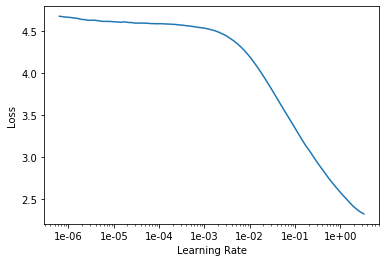

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.710863,0.213778,0.941286,00:30


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


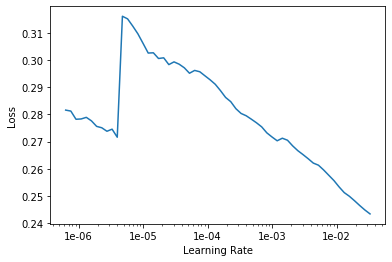

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, 1e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.238138,0.169793,0.952000,00:40
1,0.171411,0.113175,0.967545,00:40
2,0.109952,0.082161,0.976125,00:40
3,0.082325,0.077457,0.978304,00:40
4,0.065559,0.060486,0.982143,00:40
5,0.058349,0.056482,0.982759,00:40
6,0.054082,0.054696,0.983312,00:40
7,0.052142,0.054549,0.983187,00:40


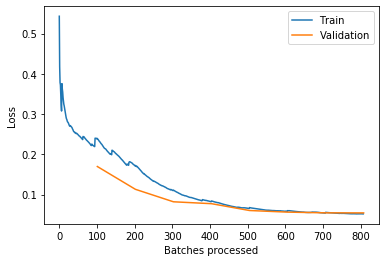

In [0]:
learn.recorder.plot_losses()

In [0]:
data_lm.train_ds

LabelList (2877 items)
x: LMTextList
xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj movement : self - winding mechanical ' , ' xxmaj power reserve : approx . 42 hours ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibration:28,800 v.p.h ' , ' xxmaj jewel:25 jewels ' , ' xxmaj calendar : xxmaj dial aperture ' , ' xxmaj case : xxmaj steel ' , ' xxmaj caseback : xxmaj screwed in ' , ' xxmaj water resistance:200 m ( 660 ft ) ' , ' xxmaj bezel : xxmaj unidirectional , ratcheted ' , ' xxmaj crown : xxmaj screw - locked , two gaskets ' , ' xxmaj crystal : xxmaj cambered sapphire , glareproofed both sides ' , ' xxmaj diameter:42.00 mm ' , ' xxmaj thickness:15.25 mm ' , ' xxmaj lug:20 / 18 mm ' ],xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj movement : self - winding mechanical ' , ' xxmaj power reserve : approx . 42 hours ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibration:28,800 v.p.h ' , ' xxmaj jewel:25 jewels

In [0]:
learn.save('/content/drive/My Drive/ulmfit')

In [0]:
learn.load('/content/drive/My Drive/Bert Training/here')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2877 items)
x: LMTextList
xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj movement : self - winding mechanical ' , ' xxmaj power reserve : approx . 42 hours ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibration:28,800 v.p.h ' , ' xxmaj jewel:25 jewels ' , ' xxmaj calendar : xxmaj dial aperture ' , ' xxmaj case : xxmaj steel ' , ' xxmaj caseback : xxmaj screwed in ' , ' xxmaj water resistance:200 m ( 660 ft ) ' , ' xxmaj bezel : xxmaj unidirectional , ratcheted ' , ' xxmaj crown : xxmaj screw - locked , two gaskets ' , ' xxmaj crystal : xxmaj cambered sapphire , glareproofed both sides ' , ' xxmaj diameter:42.00 mm ' , ' xxmaj thickness:15.25 mm ' , ' xxmaj lug:20 / 18 mm ' ],xxbos [ ' xxmaj caliber : xxmaj breitling 13 ' , ' xxmaj movement : self - winding mechanical ' , ' xxmaj power reserve : approx . 42 hours ' , ' xxmaj chronograph:1 / 4th second , 30 minutes , 12 hours ' , ' xxmaj vibr

In [0]:
def process_doc(learn, doc):
    xb, yb = learn.data.one_item(doc)
    return xb

def encode_doc(learn, doc):
    xb = process_doc(learn, doc)
    # Reset initializes the hidden state
    awd_lstm = learn.model[0]
    awd_lstm.reset()
    with torch.no_grad():
        out = awd_lstm.eval()(xb)
    # Return final output, for last RNN, on last token in sequence
    return out[0][2][0][-1].detach()

In [0]:
corpus = df['Specs']

In [0]:
corpus_embeddings = encode_doc(learn, df['Specs'])

In [0]:
queries = [df.Specs[0], df.Specs[1900], df.Specs[200]]
query_embeddings = model.encode(queries)

In [0]:
closest_n = 5
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nMost similar sentence in corpus:")

    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))





Query: ['Caliber:Breitling 13', 'Movement:self-winding mechanical', 'Power reserve:approx. 42 hours', 'Chronograph:1/4th second, 30 minutes, 12 hours', 'Vibration:28,800 v.p.h', 'Jewel:25 jewels', 'Calendar:Dial aperture', 'Case:Steel', 'Caseback:Screwed in', 'Water resistance:200 m (660 ft)', 'Bezel:Unidirectional, ratcheted', 'Crown:Screw-locked, two gaskets', 'Crystal:Cambered sapphire, glareproofed both sides', 'Diameter:42.00 mm', 'Thickness:15.25 mm', 'Lug:20/18 mm']

Most similar sentence in corpus:
['Caliber:Breitling 13', 'Movement:self-winding mechanical', 'Power reserve:approx. 42 hours', 'Chronograph:1/4th second, 30 minutes, 12 hours', 'Vibration:28,800 v.p.h', 'Jewel:25 jewels', 'Calendar:Dial aperture', 'Case:Steel', 'Caseback:Screwed in', 'Water resistance:200 m (660 ft)', 'Bezel:Unidirectional, ratcheted', 'Crown:Screw-locked, two gaskets', 'Crystal:Cambered sapphire, glareproofed both sides', 'Diameter:42.00 mm', 'Thickness:15.25 mm', 'Lug:20/18 mm'] (Score: 1.000